# LDA 

Here is some general explanation of the LDA..

In [48]:
# first load the dependencies
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
plt.rcParams['figure.figsize'] = (10, 6)

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pandas as pd
import numpy as np

# set the relevant parameters and filepath
params = ['p_uf', 'p_pu', 'p_up', 'p_fl', 'p_lu', 'ratio', 'g', 'N', 'size']
file_path = '../Data/batchrun01-02-2018.csv'

# read the data and process it
data = pd.read_csv(file_path)
cls = (data['pheromone'] + data['leaders'] + data['followers'] == 0) + \
      ((data['pheromone'] == 0) & ((data['leaders'] + data['followers']) != 0)) * 2 + \
      (((data['leaders'] == 0) & (data['followers'] == 0)) & (data['pheromone'] != 0)) * 3 + \
      ((data['leaders'] == 0) & (data['followers'] != 0)) * 4
data['class'] = cls

# extract relevant columns
X = data[params].as_matrix()
y = data['class'].as_matrix()

We start the LDA by extracting our independent variables (X) and our dependent variables (y) from the data. Then by singular-value decomposition we project this to a 2-dimensional space where the difference between the groups is maximized.

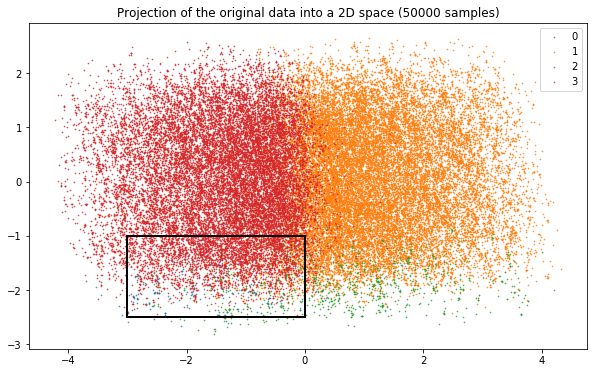

In [49]:
lda = LinearDiscriminantAnalysis(n_components=2, solver='svd')
lda.fit(X, y)

# project the data on the new axes
X_2 = lda.fit_transform(X, y)

# make a scatter plot of the projection and the classes
for group in [0, 1, 2, 3]:
    plt.scatter(X_2[y == group, 0], X_2[y == group, 1], alpha=.8, label=group, s=0.4)

plt.title("Projection of the original data into a 2D space ({} samples)".format(data.shape[0]))
plt.legend()

# highlight the interesting area
corners = np.array([[-3, -2.5],
                    [-3, -1],
                    [0, -1],
                    [0, -2.5]])
polygon = Polygon(corners, True, alpha=1, edgecolor='k', linewidth=2, fill=False)
ax = plt.gca()
ax.add_patch(polygon)


plt.show()

We now see clearly that the classes can be linearly separated in 2 dimensions. However we see that, unfortunately, the bulk of our runs has been in a very uninteresting subspace. Before we use the projection to reverse-engineer interesting parameter bounds, we first check some general descriptives of the LDA. 

In [33]:
# print the projection matrix
scalings = pd.DataFrame(lda.scalings_[:,:2].T, index=['x', 'y'], columns=params)
print("The scaling of each parameter to the axes is given in this table:\n{}\n"
      .format(scalings))

# check the relative contribution of each parameter to the axes
abs_scalings = np.abs(lda.scalings_[:,:2])
rel_scalings = (abs_scalings / np.sum(abs_scalings, axis=0)).T
rel_scalings = pd.DataFrame(rel_scalings, index=['x', 'y'], columns=params)
print("The relative scaling of each parameter to the axes is calculated by dividing the norm of each parameter \
by the row sum.\n{}\n"
      .format(rel_scalings))

# check the explained variance of the data projection
print("The two new axes of the projection explain respectively {} of the variance between the classes, and are combined \
{} of the variance.\n"
      .format(lda.explained_variance_ratio_, np.sum(lda.explained_variance_ratio_)))

The scaling of each parameter to the axes is given in this table:
       p_uf      p_pu      p_up      p_fl      p_lu     ratio         g  \
x  0.055149  4.323103 -3.532887 -0.017432 -0.316206  0.742309 -0.045370   
y -0.139787  0.275675 -0.128510 -0.144103  3.288149 -0.670756  0.023681   

          N      size  
x -0.001219 -0.006137  
y  0.004605 -0.054532  

The relative scaling of each parameter to the axes is calculated by dividing the norm of each parameter by the row sum.
       p_uf      p_pu      p_up      p_fl      p_lu     ratio         g  \
x  0.006101  0.478229  0.390814  0.001928  0.034979  0.082115  0.005019   
y  0.029555  0.058285  0.027170  0.030467  0.695199  0.141815  0.005007   

          N      size  
x  0.000135  0.000679  
y  0.000974  0.011529  

The two new axes of the projection explain respectively [ 0.95024527  0.04902577] of the variance between the classes, and are combined 0.9992710435817952 of the variance.



Not all parameters are in the same range, so the scalings are prone to misinterpretation. However we clearly see that p_up and p_pu are the main responsible parameters on the x-axis, and p_lu and the ratio are the main responsible ones for  the y-axis. If we look at the raw numbers of the scalings we can also see the effect (positive or negative) each parameter has on its position on projected space (and so on each class). Projecting our data onto these two new axes predicts basically all variance between the classes. 

Now we can check the bounds of the parameters in this space:

In [43]:
def inv_transform(lda, x):
    """
    Use the pseudo-inverse since the actual inverse does not exist.
    """
    inv = np.linalg.pinv(lda.scalings_[:,:2])
    return np.dot(x, inv) + lda.xbar_

# transform these 2D points back to their original dimension
all = inv_transform(lda, corners)

# get some basic descriptives out of these variables
mins = np.min(all, axis=0)
maxs = np.max(all, axis=0)
avgs = np.mean(all, axis=0)
minmax = pd.DataFrame(np.stack((mins, maxs, avgs)), index=['min', 'max', 'avg'], columns=params)
print("The min, max and avg values of each param in the selected area are:\n{}\n"
      .format(minmax))

The min, max and avg values of each param in the selected area are:
         p_uf      p_pu      p_up      p_fl      p_lu     ratio         g  \
min  0.507161  0.035311  0.510327  0.512139 -0.221441  0.488600  0.244825   
max  0.530898  0.477037  0.858656  0.532617  0.244009  0.647726  0.252257   
avg  0.519029  0.256174  0.684491  0.522378  0.011284  0.568163  0.248541   

              N       size  
min  105.011789  11.500383  
max  105.012514  11.508089  
avg  105.012152  11.504236  



We make a meshgrid of these min-max values and linearly interpolate them as a check if these parameters are actually in the correct space. We make a second meshgrid in which we only min-max interpolate the variables p_pu, p_up, p_lu, and ratio, and fix the other parameters. Here we see that our intuition gets confirmed that those four parameters are main effectors of their spatial localisation and we can fix the other parameters when we do a sweep in this subspace.

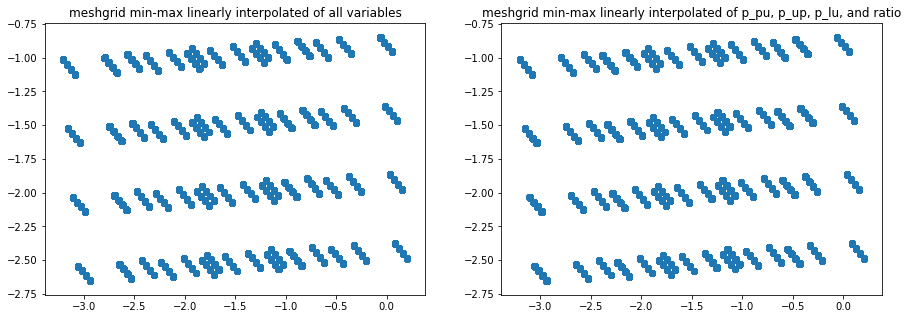

In [59]:
# lets check how well a meshgrid between the min and max of each parameter fits in between the selected area
acc = 4
param_ranges = []

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 2, 1)
for i, param in enumerate(params):
    param_ranges.append(np.linspace(mins[i],maxs[i],acc))

mesh = np.meshgrid(*param_ranges)
positions = lda.transform(np.vstack(map(np.ravel, mesh)).T)
plt.scatter(positions[:,0], positions[:,1])
plt.title("meshgrid min-max linearly interpolated of all variables")

ax = fig.add_subplot(1, 2, 2)
for i, param in enumerate(params):
    if param in ['p_pu', 'p_up', 'p_lu', 'ratio']:
        param_ranges.append(np.linspace(mins[i],maxs[i],acc))
    else:
        param_ranges.append(np.linspace(mins[i],mins[i] + 0.00001,acc))

plt.title("meshgrid min-max linearly interpolated of p_pu, p_up, p_lu, and ratio")
plt.scatter(positions[:,0], positions[:,1])

# make the final plot
plt.show()

Our new parameter sweep has been done with the parameters XXXXXXXXXXXXXXX fixed on these values and parameters XXXXXXXXXXXXXXXx bounded between XXXXXXXXXXXXXx. Here is the plot o

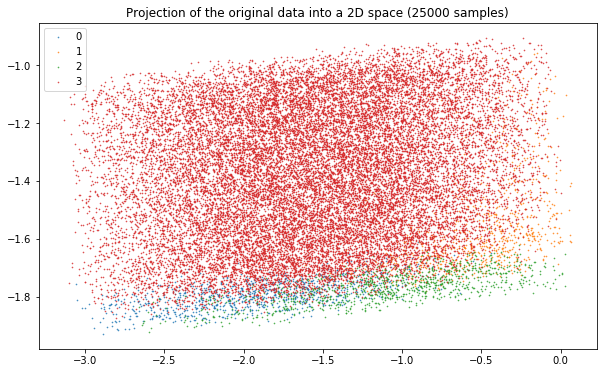

In [69]:
data = pd.read_csv('../Data/batchrun02-02-2018_square.csv')
cls = (data['pheromone'] + data['leaders'] + data['followers'] == 0) + \
      ((data['pheromone'] == 0) & ((data['leaders'] + data['followers']) != 0)) * 2 + \
      (((data['leaders'] == 0) & (data['followers'] == 0)) & (data['pheromone'] != 0)) * 3 + \
      ((data['leaders'] == 0) & (data['followers'] != 0)) * 4
data['class'] = cls

data ['N'] = 105
data ['g'] = 0.25
data ['size'] = 12
data ['p_uf'] = 0.51
data ['p_fl'] = 0.52

X = data[params].as_matrix()
X = lda.transform(X)

y = data['class'].as_matrix()
for group in [0, 1, 2, 3]:
    plt.scatter(X[y == group, 0], X[y == group, 1], alpha=.8, label=group, s=0.4)

plt.title("Projection of bou data into a 2D space ({} samples)".format(data.shape[0]))
plt.legend()
plt.show()